# EfficientNet

In [1]:
# Install and Import Required Libraries
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2025-03-05 05:42:29.037408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 05:42:29.037494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 05:42:29.037543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 05:42:31.116719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define dataset path (Modify this if needed)
DATASET_PATH = f"food-101/images"  # Change this to your dataset location

In [3]:
# Get class names (folder names)
classes = os.listdir(DATASET_PATH)
OUTPUT = 10
BATCH_SIZE = 32
N_EPOCH = 32
SEED = 42
VALID = 0.2
selected_classes = classes[:OUTPUT]  # Select first 10 classes

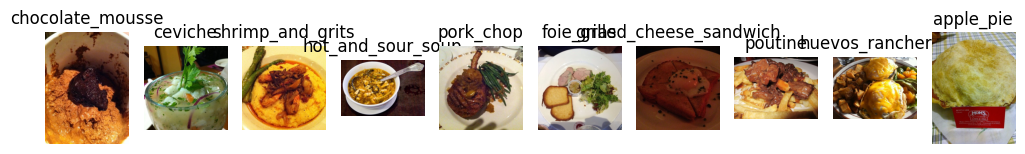

In [4]:
# Visualize sample images
fig, axes = plt.subplots(1, OUTPUT, figsize=(OUTPUT, OUTPUT))
for i, ax in enumerate(axes.flat):
    class_name = selected_classes[i]
    image_file = random.choice(os.listdir(os.path.join(DATASET_PATH, class_name)))
    img_path = os.path.join(DATASET_PATH, class_name, image_file)
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')
fig.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
def img_preprocessing(IMG_SIZE):
    # Create ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=20,  # Randomly rotate images
        width_shift_range=0.2,  # Shift width
        height_shift_range=0.2,  # Shift height
        horizontal_flip=True,  # Flip images horizontally
        validation_split=VALID  # Keep 20% for validation
    )

    # Use ImageDataGenerator instead of image_dataset_from_directory
    train_generator = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset="training",
        classes=selected_classes  # Load only selected classes
    )

    val_generator = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset="validation",
        classes=selected_classes
    )

    y_train = train_generator.classes
    y_val = val_generator.classes

    class_labels = list(val_generator.class_indices.keys())  # Class names

    return train_generator, y_train, val_generator, y_val, class_labels

In [ ]:
def gen_model(PreTrainModel, IMG_SIZE, OUTPUT):
    base_model = PreTrainModel(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    # Add custom classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Already flattens the features
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(OUTPUT, activation="softmax")  # Match output classes
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return base_model, model

In [ ]:
def train(model, train_generator, val_generator):
    # Start timing
    start_time = time.time()
    history = model.fit(train_generator, validation_data=val_generator, epochs=N_EPOCH)

    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    return history.history

In [8]:
def compile(base_model, model):
    base_model.trainable = True  # Unfreeze EfficientNet
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def predict(model, val_generator):
    # Start timing
    start_time = time.time()

    # Predict on validation data
    y_pred_probs = model.predict(val_generator)  # Get probabilities

    # End timing
    end_time = time.time()

    # Compute total and per-image inference time
    total_time = end_time - start_time  # Total time in seconds
    num_images = len(val_generator.filenames)  # Number of images
    time_per_image = total_time / num_images  # Time per image

    print("Runtime performance")
    print(f"Total inference time: {total_time:.4f} seconds")
    print(f"Time per image: {time_per_image:.6f} seconds")
    print(f"Throughput: {1 / time_per_image:.2f} images per second")

    return y_pred_probs

In [ ]:
def plot_training_history(history):
    """
    Plots the training history including accuracy and loss for both training and validation sets.

    Parameters:
    history (dict): A dictionary containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss' lists.
    """

    epochs = range(1, len(history['accuracy']) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

In [ ]:
def print_classification_report(val_generator, y_pred_probs, y_val, class_labels):
    # Get ground-truth labels

    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices

    # Generate Classification Report
    print(classification_report(y_val, y_pred, target_names=class_labels, zero_division=1))

In [ ]:
def print_confusion_matrix(val_generator, y_pred_probs, y_val, class_labels):
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

    # Generate Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
def print_evaluation(model, val_generator):
    val_loss, val_acc = model.evaluate(val_generator)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

In [14]:
def flow(MODEL, IMG_SIZE):
    # Image preprocessing & augmentation
    train_generator, y_train, val_generator, y_val, class_labels = img_preprocessing(IMG_SIZE)
    base_model, model = gen_model(MODEL, IMG_SIZE, OUTPUT)
    print("Freezed training")
    # pre-training
    train(model, train_generator, val_generator)
    compile(base_model, model)
    print("Unfreezed training")
    history = train(model, train_generator, val_generator)
    plot_training_history(history)
    y_pred_probs = predict(model, val_generator)
    print_classification_report(val_generator, y_pred_probs, y_val, class_labels)
    print_confusion_matrix(val_generator, y_pred_probs, y_val, class_labels)
    print_evaluation(model, val_generator)

## B0

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                    

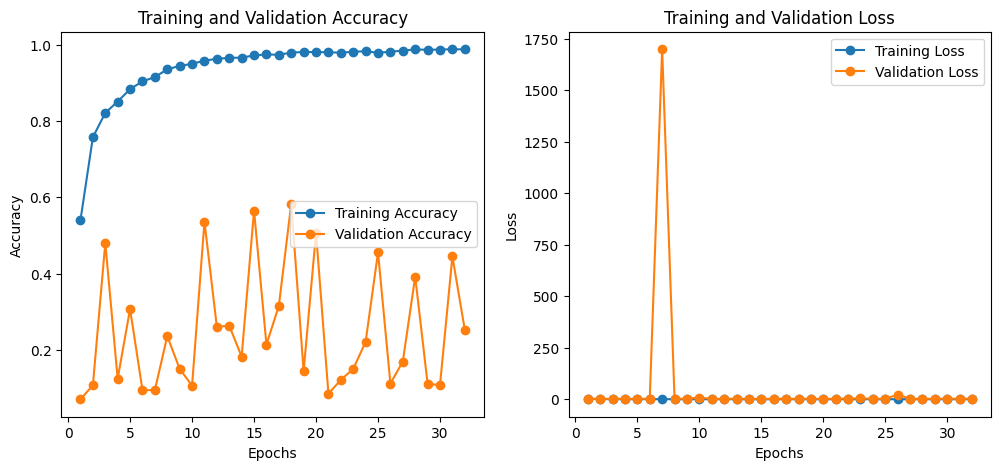

63/63 [==============================] - 53s 716ms/step
Runtime performance
Total inference time: 53.6398 seconds
Time per image: 0.026820 seconds
Throughput: 37.29 images per second
                         precision    recall  f1-score   support

       chocolate_mousse       0.06      0.02      0.03       200
                ceviche       0.09      0.09      0.09       200
       shrimp_and_grits       0.02      0.01      0.01       200
      hot_and_sour_soup       0.09      0.04      0.05       200
              pork_chop       0.03      0.01      0.01       200
              foie_gras       0.11      0.09      0.09       200
grilled_cheese_sandwich       0.11      0.04      0.06       200
                poutine       0.12      0.01      0.01       200
       huevos_rancheros       0.00      0.00      1.00       200
              apple_pie       0.10      0.64      0.17       200

               accuracy                           0.09      2000
              macro avg       0.07 

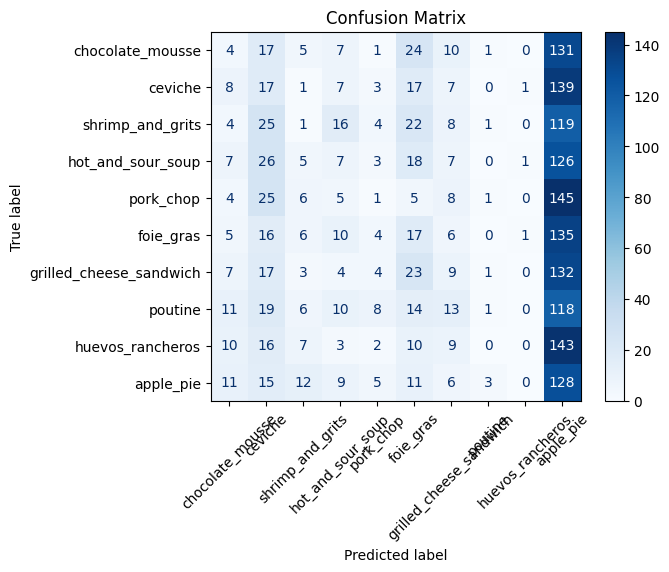

63/63 [==============================] - 47s 738ms/step - loss: 3.0928 - accuracy: 0.2575
Validation Accuracy: 0.2575
Validation Loss: 3.0928


In [15]:
from tensorflow.keras.applications import EfficientNetB0

IMG_SIZE = 224
flow(EfficientNetB0, IMG_SIZE)

## B1

In [ ]:
from tensorflow.keras.applications import EfficientNetB1

IMG_SIZE = 240
flow(EfficientNetB1, IMG_SIZE)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 8, 8, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                    